# Setup

## General

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import re
from os import chdir, getcwd, listdir, mkdir
from os.path import join
import pkg_resources
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
from scipy.linalg import norm
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [33]:
RUNNING_ON_COLAB = 'colab' in str(get_ipython())
HOME = getcwd()

In [34]:
if RUNNING_ON_COLAB == True:
    URL_FAA_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes.xlsx?raw=true"
    URL_ANAC_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-17_11-10-38.h5?raw=true"
    URL_EMBEDDING_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/embedding_layer___2021-04-17_11-10-38.h5?raw=true"
    URL_FAA_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes_labelled.xlsx?raw=true"
    URL_ANAC_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-17_10-28-55.h5?raw=true"
    URL_MODEL_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/model___2021-04-17_10-28-55___Bidirectional_GRU_Softmax.h5?raw=true"

else:
    URL_FAA_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes.xlsx?raw=true"
    URL_ANAC_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-16_16-04-53.h5?raw=true"
    URL_EMBEDDING_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/embedding_layer___2021-04-16_16-04-53.h5?raw=true"
    URL_FAA_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes_labelled.xlsx?raw=true"
    URL_ANAC_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-16_15-56-43.h5?raw=true"
    URL_MODEL_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/model___2021-04-16_15-56-43___Bidirectional_GRU_Softmax.h5?raw=true"

In [35]:
URLs = [URL_FAA_pr, URL_ANAC_pr, URL_TOKENIZER_pr, URL_EMBEDDING_pr, URL_FAA_cl, URL_ANAC_cl, URL_TOKENIZER_cl, URL_MODEL_cl]
filenames = ['FAA_pr.xlsx', 'ANAC_pr.xlsx', 'TK_pr.h5', 'EMB_pr.h5', 'FAA_cl.xlsx', 'ANAC_cl.xlsx', 'TK_cl.h5', 'MD_cl.h5']

chdir(HOME)
if 'temp' not in listdir():
    mkdir('temp')

chdir('temp')
for n in range(len(URLs)):
    r = requests.get(URLs[n])
    with open(filenames[n], 'wb') as file:
        file.write(r.content)

chdir(HOME)

233594

225438

244306

12729032

300561

225438

224139

20317912

In [36]:
filepath_FAA_pr = join(HOME, 'temp', filenames[0])
filepath_ANAC_pr = join(HOME, 'temp', filenames[1])
filepath_TK_pr = join(HOME, 'temp', filenames[2])
filepath_EMB_pr = join(HOME, 'temp', filenames[3])
filepath_FAA_cl = join(HOME, 'temp', filenames[4])
filepath_ANAC_cl = join(HOME, 'temp', filenames[5])
filepath_TK_cl = join(HOME, 'temp', filenames[6])
filepath_MD_cl = join(HOME, 'temp', filenames[7])

In [37]:
package_list = [pkg for pkg in pkg_resources.working_set]

if 'googletrans' not in [pkg.key for pkg in package_list]:
    ! pip install googletrans==3.1.0a0
import googletrans
    
if 'pdfplumber' not in [pkg.key for pkg in package_list]:
    ! pip install pdfplumber
import pdfplumber

In [38]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

## Projection

In [39]:
def relevant_words(excerpt):
    tokens = re.findall('[a-zA-Z]{3,}', excerpt)
    words, allowed_pos = [], ['NN','NNS','NNP','NNPS','JJ','RB','VB','VBG','VBN','VBP','VBZ','VBD']
    for item in nltk.pos_tag(tokens):
        if item[0] not in words and item[1] in allowed_pos:
            words.append(item[0])
    return words

def sorted_keywords(words, tokenizer):
    w,f = [], []

    for word in words:
        if word in tokenizer.word_index.keys():
            w.append(word)
            f.append(tokenizer.word_counts[word])

    sorting_indices = np.array(f).argsort()
    return np.array(w)[sorting_indices]

def jaccard_mod(string1, string2, tokenizer, max_words = None):
    # with max_words != None, repetitions are ignored, only the frequency in the original dictionary is used
    # with max_words == None, repetitions are somewhat accounted for (not very thoughtfully..)
    
    cutoff = .5
    
    if max_words == None:
        tokens1 = tokenizer.texts_to_sequences(relevant_words(string1))
        tokens2 = tokenizer.texts_to_sequences(relevant_words(string2))
    else:
        tokens1 = sorted_keywords(relevant_words(string1), tokenizer)
        tokens1 = tokenizer.texts_to_sequences(tokens1[:max_words])
        tokens2 = sorted_keywords(relevant_words(string2), tokenizer)
        tokens2 = tokenizer.texts_to_sequences(tokens2[:max_words])
        
    if len(tokens1) < 2 or len(tokens2) < 2:
        return 0
    else:
        embedding1 = embedding_layer(np.array(tokens1)).numpy().squeeze()
        norms1 = norm(embedding1, axis=1)
        embedding1 = embedding1[norms1 != 0]
        norms1 = norms1[norms1 != 0].reshape([-1,1])

        embedding2 = embedding_layer(np.array(tokens2)).numpy().squeeze()
        norms2 = norm(embedding2, axis=1)
        embedding2 = embedding2[norms2 != 0]
        norms2 = norms2[norms2 != 0].reshape([-1,1])

        cosine_similarity = np.matmul(embedding1, embedding2.T) / norms1 / norms2.T
        tril = np.ones_like(cosine_similarity) * (np.tril(cosine_similarity) != 0).astype(int)

        intersection = np.sum((cosine_similarity * cosine_similarity) > cutoff)
        union = cosine_similarity.shape[0] + cosine_similarity.shape[1] - intersection

        return intersection/union

In [40]:
df_FAA_pr = pd.read_excel(filepath_FAA_pr)[['title','requirement']]
df_ANAC_pr = pd.read_excel(filepath_ANAC_pr)[['title','requirement']]
translator = googletrans.Translator()

with open(filepath_TK_pr, 'rb') as file:
    tokenizer_pr = pickle.load(file)

with open(filepath_EMB_pr, 'rb') as file:
    embedding_layer = pickle.load(file)

## Classification

In [41]:
df_FAA_cl = pd.read_excel(filepath_FAA_cl)[['title','requirement','label','tag']]
df_ANAC_cl = pd.read_excel(filepath_ANAC_cl)[['title','requirement']] # + label + tag!!!
translator = googletrans.Translator()

with open(filepath_TK_cl, 'rb') as file:
    tokenizer_cl = pickle.load(file)
    
model = tf.keras.models.load_model(filepath_MD_cl)

sequence_length = 200

---   
# Projection

## Description

Objective: find requirements of similar semantic content.

---

<img src="https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/images/requirement_comparison.png?raw=1">

## Demo: find FAA requirement corresponding to given ANAC requirement

* Choose ANAC requirement randomly
* Translate requirement
* Compare with list of FAA requirements
    - Tokenize
    - Filter parts-of-speech
    - Sort words according to importance
    - Identify similar words
    - Compare shared words
* Print best match

Requirement: RBAC 121.287

121.287  Transporte de carga no compartimento de carga 
Carga transportada em compartimentos de carga, projetados de modo a requerer a entrada física de um tripulante para combate a qualquer incêndio que possa ocorrer em voo, deve ser distribuída de modo a permitir que um tripulante alcance, efetivamente, todas as partes do compartimento com um extintor de incêndio manual. 


Translated requirement:

121.287 Transporting cargo in the cargo hold
Cargo carried in cargo compartments, designed to require the physical entry of a crew member to fight any fire that may occur in flight, must be distributed in such a way as to allow a crew member to effectively reach all parts of the compartment with a manual fire extinguisher.


Match: FAR § 121.287
Similarity index: 0.586

Matching requirement text:

§ 121.287   Carriage of cargo in cargo compartments.
When cargo is carried in cargo compartments that are designed to require the physical entry of a crewmember to exti

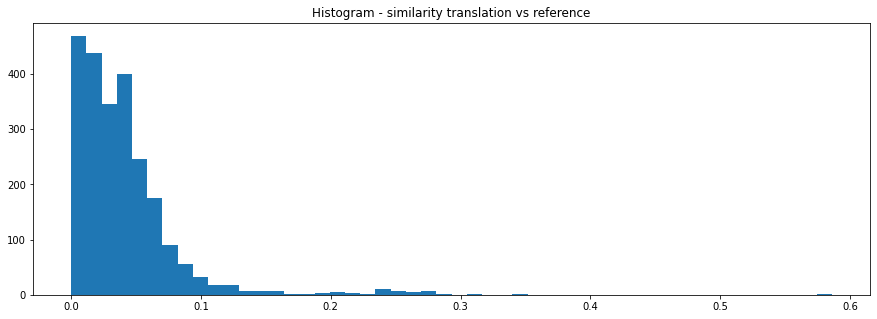

In [54]:
EXAMPLE_NUMBER = np.random.randint(0,df_ANAC_pr.shape[0])
EXAMPLE_NUMBER = 416

req = df_ANAC_pr.requirement[EXAMPLE_NUMBER]
title = df_ANAC_pr.title[EXAMPLE_NUMBER]
print('Requirement: RBAC {}\n\n{}'.format(title,req))

translation = translator.translate(req, dest='en', src='pt').text

print('\n\nTranslated requirement:\n\n{}\n\n'.format(translation))

similarity = []
for ref in df_FAA_pr.requirement:
    similarity.append(jaccard_mod(translation, ref, tokenizer_pr))
    
match_index = np.array(similarity).argmax()
print('Match: FAR {}'.format(df_FAA_pr.title[match_index]))
print('Similarity index: {}\n'.format(np.round(np.max(similarity),3)))
print('Matching requirement text:\n\n{}'.format(df_FAA_pr.requirement[match_index]))

plt.figure(figsize = (15,5));
plt.hist(np.array(similarity), 50);
plt.title('Histogram - similarity translation vs reference');
plt.show();

## Demo: find match to user input

* Ask for requirement as input (in English)
* Compare with list of FAA requirements
    - Tokenize
    - Filter parts-of-speech
    - Sort words according to importance
    - Identify similar words
    - Compare shared words
* Print best match

-> Paste an operational requirement below:

CAT.IDE.A.115    Operating lights  (a) Aeroplanes operated by day shall be equipped with:  (1) an anti-collision light system;

Match: FAR § 121.356(c)(2)
Similarity index: 0.194

Matching requirement text:

§ 121.356   Collision avoidance system.
Effective January 1, 2005, any airplane you operate under this part must be equipped and operated according to the following table: 
Collision Avoidance Systems 
If you operate any -  
Then you must operate that airplane with -  
(c) Piston-powered airplane of more than 33,000 pounds maximum certificated takeoff weight(2) A collision avoidance system equivalent to maximum TSO C-118, or a later version, or



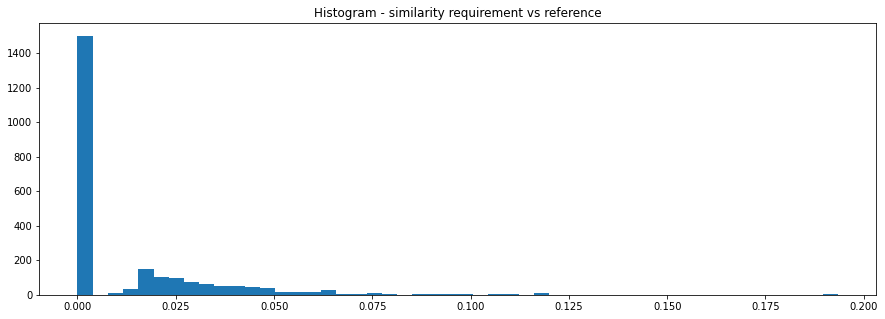

In [57]:
req = input('-> Paste an operational requirement below:\n\n')

similarity = []
for ref in df_FAA_pr.requirement:
    similarity.append(jaccard_mod(req, ref, tokenizer_pr))
    
match_index = np.array(similarity).argmax()
print('\nMatch: FAR {}'.format(df_FAA_pr.title[match_index]))
print('Similarity index: {}\n'.format(np.round(np.max(similarity), 3)))
print('Matching requirement text:\n\n{}'.format(df_FAA_pr.requirement[match_index]))

plt.figure(figsize = (15,5));
plt.hist(np.array(similarity), 50);
plt.title('Histogram - similarity requirement vs reference');
plt.show();

---   
# Classification

## Description

Objective: read requirement and classify in either "Title Only", "Aircraft" or "Operator"   

-----   

<img src="https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/images/requirement_classification.png?raw=1">

## Demo: classify random FAA requirement

* Select FAA part 121 requirement randomly
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [60]:
EXAMPLE_NUMBER = np.random.randint(0,df_FAA_cl.shape[0])

req = df_FAA_cl.requirement[EXAMPLE_NUMBER]
title = df_FAA_cl.title[EXAMPLE_NUMBER]
correct_tag = df_FAA_cl.tag[EXAMPLE_NUMBER].title()
print('Requirement: {}\n\n{}'.format(title,req))

tokens = tokenizer_cl.texts_to_sequences([req])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = tf.constant(np.array(padded_tokens))
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('Predicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))
print('\nCorrect label: {}'.format(correct_tag))

Requirement: § 121.327(c)(2)

§ 121.327   Supplemental oxygen: Reciprocating engine powered airplanes.
(c) Passengers. Each certificate holder shall provide a supply of oxygen, approved for passenger safety, in accordance with the following: 
(2) For flights at cabin pressure altitudes above 14,000 feet up to and including 15,000 feet, enough oxygen for that part of the flight at those altitudes for 30 percent of the passengers. 

Predicted label: Aircraft
Level of Confidence: 99.731%

Correct label: Aircraft


## Demo: classify random ANAC requirement

* Select ANAC RBAC 121 requirement randomly
* Translate to English
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [62]:
EXAMPLE_NUMBER = np.random.randint(0,df_ANAC_cl.shape[0])

req = df_ANAC_cl.requirement[EXAMPLE_NUMBER]
title = df_ANAC_cl.title[EXAMPLE_NUMBER]
#correct_tag = df_ANAC.tag[EXAMPLE_NUMBER].title()
print('Requirement: {}\n\n{}'.format(title,req))

translation = translator.translate(req, dest='en', src='pt').text

print('\n\nTranslated requirement:\n\n{}\n\n'.format(translation))

tokens = tokenizer_cl.texts_to_sequences([translation])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = np.array(padded_tokens)
X = tf.constant(X)
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('Predicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))
#print('\nCorrect label: {}'.format(correct_tag))

Requirement: 121.715(a)(11)

121.715  Diário de bordo 
(a) O detentor de certificado deverá levar em cada voo o diário de bordo do avião, ou equivalente aceitável pela ANAC, com no mínimo, mas não limitado aos seguintes dados: (11) horas de voo por etapa/total; 


Translated requirement:

121,715 Logbook
(a) The certificate holder shall carry on each flight the airplane's logbook, or equivalent acceptable by ANAC, with at least, but not limited to the following data: (11) flight hours per stage / total;


Predicted label: Operator
Level of Confidence: 99.813%


## Demo: classify user input

* Ask for requirement as input (in English)
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [63]:
REQUIREMENT = input('-> Paste an operational requirement below:\n\n')

tokens = tokenizer_cl.texts_to_sequences([REQUIREMENT])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = np.array(padded_tokens)
X = tf.constant(X)
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('\nPredicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))

-> Paste an operational requirement below:

CAT.IDE.A.115    Operating lights  (a) Aeroplanes operated by day shall be equipped with:  (1) an anti-collision light system;

Predicted label: Operator
Level of Confidence: 90.433%
